<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/HM_04_Cross%20Price%20Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', 120)


# Data Extraction

In [2]:
# 👇 set this to your uploaded file name (e.g., "stores.csv.zip" or "stores.csv.7z")
ARCHIVE_PATH = "/content/softDrinks.csv.zip"  # or "stores.csv.7z"

import os, zipfile, subprocess

EXTRACT_DIR = "./extracted"
os.makedirs(EXTRACT_DIR, exist_ok=True)

if ARCHIVE_PATH.lower().endswith(".zip"):
    with zipfile.ZipFile(ARCHIVE_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)
elif ARCHIVE_PATH.lower().endswith(".7z"):
    # install 7z once per session
    subprocess.run(["apt-get","update","-qq"], check=True)
    subprocess.run(["apt-get","install","-y","p7zip-full"], check=True)
    subprocess.run(["7z","x",ARCHIVE_PATH,f"-o{EXTRACT_DIR}"], check=True)
else:
    raise ValueError("Unsupported archive type. Use .zip or .7z")

# list extracted files
for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        print(os.path.join(root, f))


./extracted/softDrinks.csv


In [3]:
!pip install chardet

import chardet

with open("/content/extracted/softDrinks.csv", 'rb') as f:
    result = chardet.detect(f.read(1000000))  # read first 1MB
print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [ ]:
csv_path = "/content/extracted/softDrinks.csv"

chunksize = 500_000  # adjust based on RAM (~0.5M rows per chunk)

for chunk in pd.read_csv(csv_path, encoding="cp1252", encoding_errors="replace", chunksize=chunksize):
    # Example: work with the chunk here
    print(chunk.shape)
    print(chunk.head(2))
    # break  # remove if you want to process all chunks


(500000, 14)
   UPC  STORE  WEEK  MOVE  QTY  PRICE SALE  PROFIT  OK  COM_CODE  \
0  179      2     1     1    1   10.0  NaN    99.9   1       225   
1  179      2     2     0    1    0.0  NaN     0.0   1       225   

                DESCRIP  SIZE  CASE    NITEM  
0  BLOOD GLUCOSE SCREEN  EACH     1  9990290  
1  BLOOD GLUCOSE SCREEN  EACH     1  9990290  
(500000, 14)
        UPC  STORE  WEEK  MOVE  QTY  PRICE SALE  PROFIT  OK  COM_CODE  \
500000  447     94   379     0    1   0.00  NaN    0.00   1       235   
500001  447     54   392    40    1   5.99    S   -0.16   1       235   

            DESCRIP    SIZE  CASE  NITEM  
500000  SQUIRT SODA  24/12O     1  62520  
500001  SQUIRT SODA  24/12O     1  62520  
(500000, 14)
                UPC  STORE  WEEK  MOVE  QTY  PRICE SALE  PROFIT  OK  COM_CODE  \
1000000  1060880027    121   239     3    1   1.19  NaN   20.16   1       238   
1000001  1060880027     78   307     0    1   0.00  NaN    0.00   1       238   

                      

/tmp/ipython-input-246842685.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_path, encoding="cp1252", encoding_errors="replace", chunksize=chunksize):


In [5]:
csv_path = "/content/extracted/softDrinks.csv"
chunksize = 500_000
max_chunks = 20   # <- control how big the final DF gets

dfs = []
for i, chunk in enumerate(pd.read_csv(
        csv_path,
        encoding="cp1252",
        encoding_errors="replace",
        chunksize=chunksize,
        low_memory=False)):
    dfs.append(chunk)
    if i + 1 >= max_chunks:
        break

df = pd.concat(dfs, ignore_index=True)
print(df.shape)

(10000000, 14)


# Data Exploration

In [6]:
df.columns

Index(['UPC', 'STORE', 'WEEK', 'MOVE', 'QTY', 'PRICE', 'SALE', 'PROFIT', 'OK',
       'COM_CODE', 'DESCRIP', 'SIZE', 'CASE', 'NITEM'],
      dtype='object')

> **Aligned with Dominick’s schema you shared**: `['UPC','STORE','WEEK','MOVE','QTY','PRICE','SALE','PROFIT','OK','COM_CODE','DESCRIP','SIZE','CASE','NITEM']`
>
> **Data Dictionary:**
> - **UPC**: Universal Product Code (identifier for the product)
> - **STORE**: Store ID where the sales occurred
> - **WEEK**: Week number in the dataset’s time frame
> - **MOVE**: Total number of units sold (quantity sold)
> - **QTY**: Package size (number of items per pack or volume equivalent)
> - **PRICE**: Total price for the package (not unit price)
> - **SALE**: Promotion flag (1 if on sale/promotion, 0 otherwise)
> - **PROFIT**: Profit from the sale (currency)
> - **OK**: Data validity flag (1 = valid record, 0 = exclude)
> - **COM_CODE**: Commodity code/category ID
> - **DESCRIP**: Product description (brand, pack size, flavor)
> - **SIZE**: Text description of package size (e.g., 2 L, 12 oz)
> - **CASE**: Case size or count (may be redundant with QTY)
> - **NITEM**: Number of items in a package (related to QTY)

> Key modeling choices:
> - Use **`MOVE`** as quantity sold (units)
> - Compute **unit price** as **`PRICE / QTY`** (so bundles/sizes normalize correctly)
> - Keep only valid rows: **`OK==1`**, positive **`MOVE`**, **`QTY`**, **`PRICE`**
> - Derive **BRAND** from `DESCRIP` and aggregate to **STORE–WEEK–BRAND**
> - Build a **store–week wide panel** and estimate **own & cross-price elasticities** with **fixed effects**

In [7]:
df.head(2)

,UPC,STORE,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,COM_CODE,DESCRIP,SIZE,CASE,NITEM
0,179.0,2,1,1,1,10.0,NaN,99.9,1,225,BLOOD GLUCOSE SCREEN,EACH,1,9990290
1,179.0,2,2,0,1,0.0,NaN,0.0,1,225,BLOOD GLUCOSE SCREEN,EACH,1,9990290


In [8]:
df.describe()

,UPC,STORE,WEEK,MOVE,QTY,PRICE,PROFIT,OK,COM_CODE,CASE,NITEM
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,10000000.0,1.000000e+07,1.000000e+07,1.000000e+07
mean,2.539329e+09,8.355202e+01,2.342640e+02,1.973564e+01,1.086982e+00,1.512294e+00,1.241184e+01,1.0,2.353675e+02,7.592532e+00,-4.788767e+03
std,1.491503e+09,3.670577e+01,1.097501e+02,7.794551e+01,7.235987e-01,1.958089e+00,2.075390e+01,0.0,4.035027e+00,7.259001e+00,5.352715e+06
min,1.790000e+02,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-9.999000e+01,1.0,2.250000e+02,1.000000e+00,-2.684388e+08
25%,1.200001e+09,5.600000e+01,1.540000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.0,2.350000e+02,2.000000e+00,5.212000e+04
50%,2.950001e+09,8.900000e+01,2.440000e+02,3.000000e+00,1.000000e+00,9.300000e-01,7.910000e+00,1.0,2.370000e+02,4.000000e+00,5.538000e+04
75%,3.828100e+09,1.140000e+02,3.290000e+02,1.300000e+01,1.000000e+00,2.090000e+00,2.602000e+01,1.0,2.380000e+02,8.000000e+00,6.217000e+04
max,4.900001e+09,1.460000e+02,3.990000e+02,9.487000e+03,2.400000e+01,5.555000e+01,9.999000e+01,1.0,2.410000e+02,4.800000e+01,9.990290e+06


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 14 columns):
 #   Column    Dtype  
---  ------    -----  
 0   UPC       float64
 1   STORE     int64  
 2   WEEK      int64  
 3   MOVE      int64  
 4   QTY       int64  
 5   PRICE     float64
 6   SALE      object 
 7   PROFIT    float64
 8   OK        int64  
 9   COM_CODE  int64  
 10  DESCRIP   object 
 11  SIZE      object 
 12  CASE      int64  
 13  NITEM     int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ GB


In [10]:
# Filter valid rows per docs
df = df[(df['OK'] == 1) & (df['PRICE'] > 0) & (df['MOVE'] > 0) & (df['QTY'] > 0)].copy()

In [11]:
df.shape

(6499991, 14)

In [12]:
# Compute unit price (handles packs/sizes)
df['unit_price'] = df['PRICE'] / df['QTY']

In [13]:
# Brand extraction – tweak this regex for your category
brand_regex = r'(COKE|PEPSI|SPRITE|7\s*UP|MOUNTAIN\s*DEW|DIET\s*COKE|DIET\s*PEPSI)'
df['BRAND'] = df['DESCRIP'].str.upper().str.extract(brand_regex, expand=False)

In [14]:
df['BRAND'].unique()

array([nan, 'PEPSI', 'DIET PEPSI', 'MOUNTAIN DEW', '7 UP', 'COKE',
       'DIET COKE', 'SPRITE'], dtype=object)

In [15]:
# Keep top brands to simplify cross effects (3–5 brands recommended)
top_brands = df['BRAND'].value_counts().head(5).index.tolist()
df = df[df['BRAND'].isin(top_brands)].copy()

In [16]:
df.shape

(1396792, 16)

In [18]:
df.head()

,UPC,STORE,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,COM_CODE,DESCRIP,SIZE,CASE,NITEM,unit_price,BRAND
5836,418.0,71,306,3,1,6.99,S,10.58,1,235,~DIET CRYSTAL PEPSI,24/12O,1,54950,6.99,PEPSI
5846,418.0,71,308,2,1,6.99,B,-47.35,1,235,~DIET CRYSTAL PEPSI,24/12O,1,54950,6.99,PEPSI
5865,418.0,71,300,4,1,5.99,S,-4.34,1,235,~DIET CRYSTAL PEPSI,24/12O,1,54950,5.99,PEPSI
5908,418.0,107,349,2,1,6.99,NaN,-3.71,1,235,~DIET CRYSTAL PEPSI,24/12O,1,54950,6.99,PEPSI
5909,418.0,71,303,7,1,6.99,B,-47.35,1,235,~DIET CRYSTAL PEPSI,24/12O,1,54950,6.99,PEPSI


In [19]:
# Quick sanity
print('Top brands:', top_brands)
df[['STORE','WEEK','DESCRIP','MOVE','QTY','PRICE','unit_price','BRAND']].head()

Top brands: ['PEPSI', 'MOUNTAIN DEW', 'DIET PEPSI', 'COKE', 'SPRITE']


,STORE,WEEK,DESCRIP,MOVE,QTY,PRICE,unit_price,BRAND
5836,71,306,~DIET CRYSTAL PEPSI,3,1,6.99,6.99,PEPSI
5846,71,308,~DIET CRYSTAL PEPSI,2,1,6.99,6.99,PEPSI
5865,71,300,~DIET CRYSTAL PEPSI,4,1,5.99,5.99,PEPSI
5908,107,349,~DIET CRYSTAL PEPSI,2,1,6.99,6.99,PEPSI
5909,71,303,~DIET CRYSTAL PEPSI,7,1,6.99,6.99,PEPSI


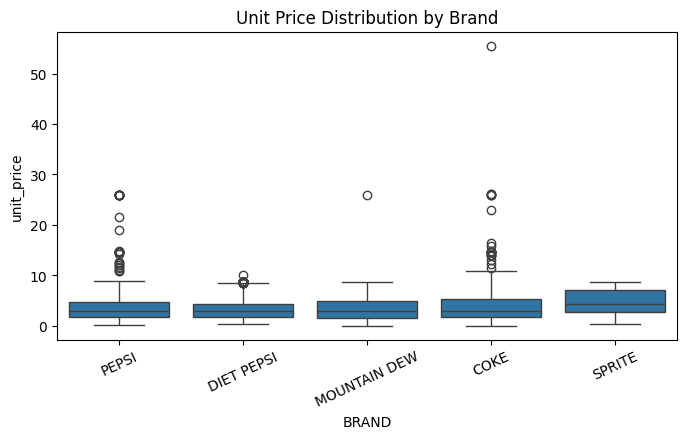

In [20]:
# 2) EDA (light)
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='BRAND', y='unit_price')
plt.title('Unit Price Distribution by Brand')
plt.xticks(rotation=25)
plt.show()